In [1]:
# Import libraries
# For data analysis
import pandas as pd
import numpy as np
import re

# For plotting graphs and visualization
import seaborn as sn
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For NLP
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline # For setting up pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
# Load data
testdf = pd.read_csv('../Tweeter for Disaster/test.csv',
                   dtype ={'id':np.int16})
traindf = pd.read_csv('../Tweeter for Disaster/train.csv',
                    dtype={'id': np.int16, 'target': np.int8})

# Check info and missing values
testdf.info() 
traindf.info()
testdf.describe()
traindf.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int16 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int16(1), object(3)
memory usage: 83.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int16 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int8  
dtypes: int16(1), int8(1), object(3)
memory usage: 200.9+ KB


,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


We see that both test and train df contain null values in keyword and location columns. We will see how they are related to deal with null values.

/Applications/anaconda3/envs/tf/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


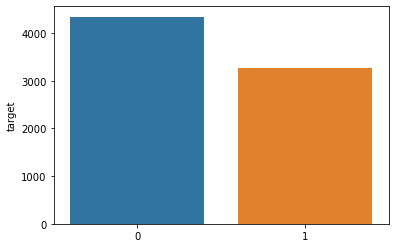

In [3]:
# Check for class distribution
x = traindf.target.value_counts()
chart = sn.barplot(x.index,x)  #more non disasters than disasters


So there are two classes in the dataset, 0 and 1. And it is skewed towards 0. But since the difference is not too big, we will not fix the imbalance class. 

<AxesSubplot:xlabel='Num_word', ylabel='keyword'>

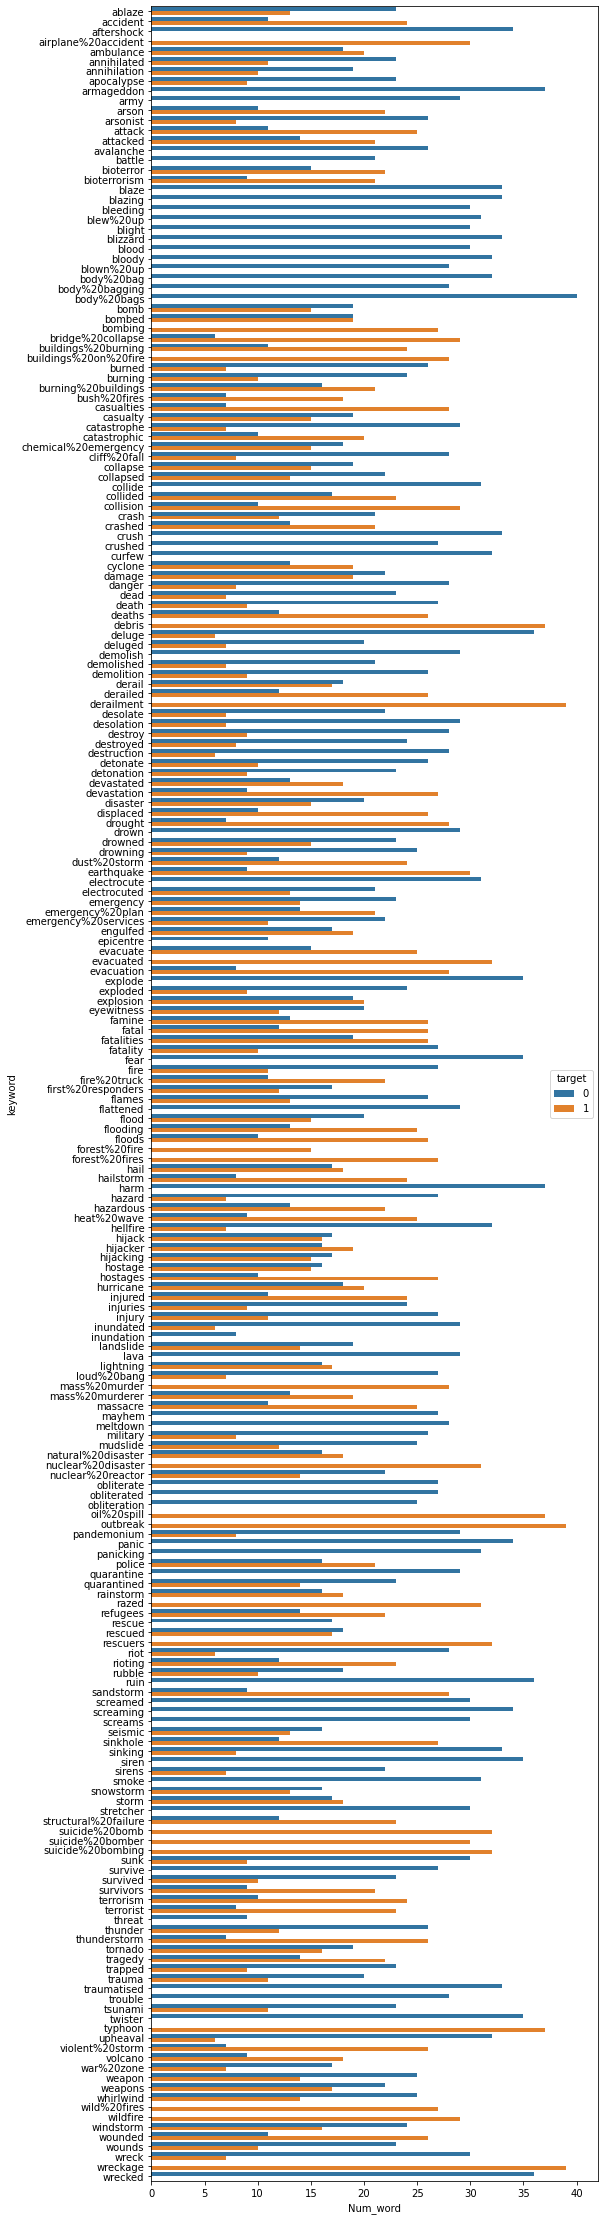

In [73]:
plot = traindf.groupby(['keyword','target']).agg(Num_word = ('id','size')).reset_index()
plot = plot[plot.Num_word > 5]
plt.figure(figsize=(8,40))
sn.barplot(y = 'keyword', x = 'Num_word',hue ='target',data = plot)

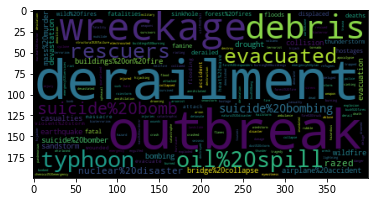

In [74]:
# Helper function for Wordcloud
def wordcloud_class(df, target):
    
    class_target = traindf[traindf.target == target]
    class_target = class_target.groupby(['keyword'])['id'].count().reset_index()
    class_targetdict = dict(zip(class_target.keyword,class_target.id))
    wordc = WordCloud().generate_from_frequencies(class_targetdict)
    plt.imshow(wordc)

# Wordcloud for class 1
wordcloud_class(traindf,1)

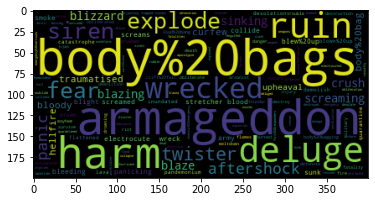

In [75]:
# Wordcloud for class 0
wordcloud_class(traindf,0)

In [88]:
# Check word count for each class
traindf['word_count'] = traindf['text'].apply(lambda x: len(str(x).split(' ')))
testdf['word_count'] = testdf['text'].apply(lambda x: len(str(x).split(' ')))

# Check number of punctuations
traindf['punctuation_count'] = traindf['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))
testdf['punctuation_count'] = testdf['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

# Check number of urls
traindf['url_count'] = traindf['text'].apply(lambda x: len([i for i in str(x).lower() if ('http' in i or 'https' in i)]))

# Check disaster keywords
disaster = ['wildfire','flooding','hurricane','earthquake','tornado','volcano','fire']
traindf['disaster_count'] = traindf['text'].apply(lambda x: len([i for i in str(x).split(' ') if i in disaster]))
traindf[(traindf.disaster_count == 0)]['disaster_count'].min()
traindf[(traindf.disaster_count == 1)]['disaster_count'].min()

# Check for duplicates and mislabelling
duplicated_values = traindf[traindf.text.duplicated()]
duplicated_test = testdf[testdf.text.duplicated()]

duplicated = duplicated_values.groupby(['text']).agg(list).target.reset_index()
duplicated = duplicated[duplicated.target.apply(lambda x: len(x) >2)]


/Applications/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


[Text(0, 0, '0'), Text(1, 0, '1')]

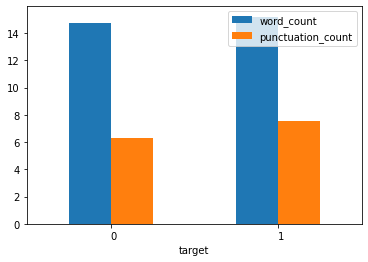

In [77]:
# Plot to see any stark difference
ax = traindf.groupby(['target'])['word_count','punctuation_count'].mean().plot(kind = 'bar')
ax.set_xticklabels(labels = ['0','1'],rotation = 0, ha = 'left')

In [78]:
# Clean up duplicates
def remove_mislabelling(df):
    df.loc[df.text == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4','target'] = 0
    df.loc[df.text == 'He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam','target'] = 0
    df.loc[df.text == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.",'target'] = 0
    df.loc[df.text == 'To fight bioterrorism sir.','target'] = 0
    df.loc[df.text == 'that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time','target'] = 0
    
    return df

In [79]:
# Data cleaning helper functions
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return(text.translate(table))

def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# https://stackoverflow.com/a/49146722/330558
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

stopwords = set(stopwords.words('english'))
def remove_stopwords(text):
    filtered =[i for i in word_tokenize(text) if not i.lower() in stopwords]
    return filtered

In [81]:
# Apply data cleaning to dataframe
traindf['text'] = traindf['text'].apply(lambda x : remove_url(x))
traindf['text'] = traindf['text'].apply(lambda x : remove_emoji(x))
traindf['text'] = traindf['text'].apply(lambda x : remove_punct(x))
traindf = remove_mislabelling(traindf)

In [82]:
# After cleaning the data, I will split the training data into test and training set

label = traindf.target
features = traindf[['id', 'keyword', 'location', 'text','disaster_count']]
X_train, X_test, y_train, y_test = train_test_split(features,label,test_size = 0.33,random_state= 42)

In [83]:
# Model training
count_vect = CountVectorizer()
tfidf = TfidfTransformer()
X_train = X_train['text']
X_test = X_test['text']
X_train_counts = count_vect.fit_transform(X_train)
X_train_tfidf = tfidf.fit_transform(X_train_counts)

svm = LinearSVC()
svm.fit(X_train_tfidf,y_train)
y_pred = svm.predict(count_vect.transform(X_test))
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.84      0.68      0.75      1446
           1       0.66      0.82      0.73      1067

    accuracy                           0.74      2513
   macro avg       0.75      0.75      0.74      2513
weighted avg       0.76      0.74      0.74      2513



In [84]:
# Base case
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)
y_pred = mnb.predict(count_vect.transform(X_test))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.91      0.84      1446
           1       0.84      0.66      0.74      1067

    accuracy                           0.80      2513
   macro avg       0.81      0.79      0.79      2513
weighted avg       0.81      0.80      0.80      2513



This will be my base case and I plan to improve the model by incorporating the disaster_count column using pipe object.

In [92]:
X_train, X_test, y_train, y_test = train_test_split(features,label,test_size = 0.33,random_state= 42)
def get_numeric_data(x):
    data = [r for r in x.disaster_count]
    return(data)

def get_text_data(x):
    corpus = [r for r in x.text] 
   # print('text shape:', [record[-1] for record in x])
    return(corpus)

transfomer_numeric = FunctionTransformer(get_numeric_data)
transformer_text = FunctionTransformer(get_text_data)
    
#feature1 = Pipeline([('selector',transfomer_numeric)])
#feature2 = Pipeline([('selector',transformer_text),('vec',TfidfVectorizer(analyzer='word'))])

pipe = Pipeline([('features',FeatureUnion([
       ('numeric',Pipeline([('selector',transfomer_numeric)])),
       ('text',Pipeline([('selector',transformer_text),('vec',TfidfVectorizer(stop_words= 'english',analyzer='word'))])
        )])),
    ('clf', RandomForestClassifier())])

pipe.fit_transform(X_train,y_train)
print('Test set score: ' + str(pipe.score(X_test,y_test)))


ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 5100, expected 1.

In [89]:
Still trying to fix this bug...

Index(['id', 'keyword', 'location', 'text', 'target', 'mean', 'word_count',
       'punctuation_count', 'url_count', 'disaster_count'],
      dtype='object')

In [ ]:
#try to explore whether the keywords exist in the tweet. If yes, can be one hot encoded and use to train 